In [1]:
# imports
import numpy as np
import pandas as pd
import json
import requests
import os
import sys
from operator import itemgetter

# set up file paths and other data globals

import config, modify

sys.path.append(config.CURRENT_DIR_STR)
sys.path.append(config.COVID_PACKAGE_STR)
sys.path.append(config.UPDATE_FILE_STR)

# local imports

from covid_package.data_funcs.store_data import read_json_data, convert_owid_data, print_update_record
from covid_package.data_funcs.update_data import check_refresh_data

from covid_package.libs.valid_keys import fetch_l0_keys, fetch_l1_keys, fetch_l2_keys
from covid_package.libs.aggregate_data import fetch_latest_data_date, fetch_date_list
from covid_package.libs.country_list import fetch_countries

from covid_package.api.get_country_records import get_country_records
from covid_package.api.get_country_data import get_l0_data, get_l1_data, get_l2_iso_data, get_l2_date_data
from covid_package.api.get_case_death_data import get_case_death_stdev

from covid_package.plots.plot_results import line_plot

from covid_package.plots.plot_results import subplot_share_axis

In [2]:
# update data

if check_refresh_data():
    # read the updated(?) data file from the data dir
    data = read_json_data(config.DATA_FILE_STR)
    # convert the OWID_ keys
    data = convert_owid_data(data)
    # repopulate the keys
    key_list = fetch_l0_keys(data)
    # need this?
    #country_list = fetch_countries(data)
    # get the date of the newest data records in owid-covid-data.json
    print("Latest data is:", fetch_latest_data_date(data, key_list))

Checking that data is up to date
Data file up to date
Latest data is: 2021-04-21


In [6]:
#[print(k) for k in key_list]

# get the data for a single country
#print(get_l0_data(data, 'GBR'))

# get the level 1 data for all countries
#print(get_l1_data(data, key_list, ['population']))

# list of valid level 1 keys
#print(fetch_l1_keys(data, key_list))

# list of valid level 2 keys
#print(fetch_l2_keys(data, key_list))

# for each country, get record numbers and data dates
print(get_country_records(data, key_list))

# get an exhaustive list of dates in the data
date_list = fetch_date_list(data, key_list)

# define the list of required resources
res = ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million']

# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, key_list, date_list, res)

print("Country_date_data complete...")


AFG: Afghanistan = 422; from 2020-02-24 to 2021-04-20.
ALB: Albania = 421; from 2020-02-25 to 2021-04-20.
DZA: Algeria = 421; from 2020-02-25 to 2021-04-20.
AND: Andorra = 415; from 2020-03-02 to 2021-04-20.
AGO: Angola = 397; from 2020-03-20 to 2021-04-20.
AIA: Anguilla = 68; from 2021-02-04 to 2021-04-12.
ATG: Antigua and Barbuda = 404; from 2020-03-13 to 2021-04-20.
ARG: Argentina = 476; from 2020-01-01 to 2021-04-20.
ARM: Armenia = 416; from 2020-03-01 to 2021-04-20.
ABW: Aruba = 1; from 2021-04-20 to 2021-04-20.
AUS: Australia = 451; from 2020-01-26 to 2021-04-20.
AUT: Austria = 421; from 2020-02-25 to 2021-04-20.
AZE: Azerbaijan = 416; from 2020-03-01 to 2021-04-20.
BHS: Bahamas = 401; from 2020-03-16 to 2021-04-20.
BHR: Bahrain = 422; from 2020-02-24 to 2021-04-20.
BGD: Bangladesh = 414; from 2020-03-03 to 2021-04-20.
BRB: Barbados = 400; from 2020-03-17 to 2021-04-20.
BLR: Belarus = 418; from 2020-02-28 to 2021-04-20.
BEL: Belgium = 442; from 2020-02-04 to 2021-04-20.
BLZ: Bel

In [4]:
# cycle through each day's collections of new cases and new deaths

date_dict = dict()
for day in country_date_data:

    #print(country_date_data[day])

    # calculate the wrl_new_ cases/deaths _per_million
    if country_date_data[day]['WRL'][1]:
        wrl_new_cases_pm = country_date_data[day]['WRL'][1]
    else:
        wrl_new_cases_pm = 0
    
    if country_date_data[day]['WRL'][1]:
        wrl_new_deaths_pm = country_date_data[day]['WRL'][1]
    else:
        wrl_new_deaths_pm = 0

    # pop the wrl vals out of the structure
    # so they don't screw up the stdev calculation
    country_date_data[day].pop('WRL')

    # calculate the std dev for the day
    mean_stdev = get_case_death_stdev(country_date_data[day])

    """
    # safety checks

    if mean_stdev[0] != wrl_new_cases_pm:
        print('Deviation: for {}, WRL new_cases_per_million = {}; calcuated value = {}'.format(day, wrl_new_cases_pm, mean_stdev[0]))

    if mean_stdev[2] != wrl_new_deaths_pm:
        print('Deviation: for {}, WRL new_deaths_per_million = {}; calcuated value = {}'.format(day, wrl_new_deaths_pm, mean_stdev[2]))
    """

    # populate the date dict for this day
    date_dict[day] = {
        "wrl_new_cases_pm": wrl_new_cases_pm,
        "wrl_new_deaths_pm": wrl_new_deaths_pm,
        "stdev_new_cases_pm": mean_stdev[0],
        "stdev_new_deaths_pm": mean_stdev[1],
        "country_vals": country_date_data[day]
    }

test_date = '2020-04-01'
#print(date_dict[test_date])

In [5]:
# re-juggle the data for the chart

#y_axis_values = 'wrl_new_cases_pm'
y_axis_values = 'wrl_new_deaths_pm'

y1_axis_values = 'IND'

x_axis = []
y_axis = []
y1_axis = []

min_x = '2020-01-01'
min_y = 0
max_x = '2020-01-01'
max_y = 0

for key, val in date_dict.items():
    
    if key > max_x:
        max_x = key
    if val[y_axis_values] > max_y:
        max_y = val[y_axis_values]

    if val['country_vals'][y1_axis_values][1] > max_y:
        max_y = val['country_vals'][y1_axis_values][1]    

    x_axis.append(key)    
    y_axis.append(val[y_axis_values])
    y1_axis.append(val['country_vals'][y1_axis_values][1])

print(max_x)
print(max_y)    
    

KeyError: 'IND'

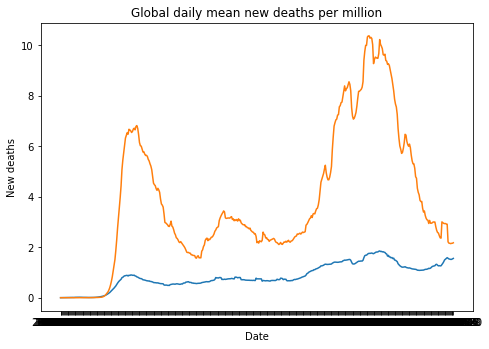

In [7]:
# package up the matplotlib data

# create the labels
labels_obj = {}
labels_obj['chart_title'] = "Global daily mean new deaths per million"
labels_obj['x_axis_label'] = "Date"
labels_obj['y_axis_label'] = "New deaths"

#labels_obj['y_axis_label'] = "Mean new cases"

labels_obj['legend_1'] = "New cases"
#labels_obj['legend_2'] = "New deaths"


# package the results
results_obj = {}

results_obj['x_axis'] = x_axis
results_obj['y_axis'] = y_axis
results_obj['y1_axis'] = y1_axis

# pacakge the params
params_obj = {}

params_obj['axis_settings'] = [min_x, min_y, max_x, max_y]


# call matplotlib driver function
line_plot(labels_obj, results_obj, params_obj)
